## Goal

Fit 3 STAN models to censored data, and see how well they do.

Steps:
1. Load censored data
2. Load STAN models
    * truncated
    * censored with marginalization
    * censored with latent variable
3. For each model:
  * fit model
  * compare estimates of parameters with empirical parameters of original data

In [1]:
import numpy as np
import time
import pystan
import sys
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import norm

sys.path.append('../')
from utils.stan_utilities import \
    get_model, \
    plot_traces, \
    plot_posteriors, \
    posterior_stats
from utils.plot_utilities import \
    add_margin, \
    equalize_xy, \
    plot_gaussian_contour

### 1. Load censored data

In [2]:
data_file = '../data/censored_data.npy'
data_censored = np.load(data_file)
Ntotal = data_censored.shape[0]

# determine censoring boundary using exreme values
ylow = np.min(data_censored[:, 1])
yhigh = np.max(data_censored[:, 1])

In [3]:
data = {
    'eps': 1e-5,
    'y_low': ylow,
    'y_high': yhigh,
    'N': Ntotal,
    'x': data_censored[:, 0],
    'y': data_censored[:, 1]
}

### 2. Load models

In [4]:
stan_directory = '../stan_code/'
truncated_model = get_model(stan_directory + '2D-truncated-normal.stan', 
                            stan_directory + '2D-truncated-normal.pkl')
censored_model = get_model(stan_directory + '2D-censored-normal-marginalized.stan', 
                           stan_directory + '2D-censored-normal-marginalized.pkl')
censored_latent_model = get_model(stan_directory + '2D-censored-normal-w-1D-latent-optimized.stan', 
                                  stan_directory + '2D-censored-normal-w-1D-latent-optimized.pkl')

### 3. Fit models

In [5]:
# functions to extract mu and Sigma from STAN posterior stats

def mean_mu(fit):
    pars = posterior_stats(fit)['par']
    mu = np.zeros(2)
    for idx in (0,1):
        mu[idx] = posterior_stats(fit)['mean'][
            pars.index('mu[{}]'.format(idx))]
    return mu

def mean_Sigma(fit):
    pars = posterior_stats(fit)['par']
    Sigma = np.zeros([2,2])
    for idx1 in (0,1):
        for idx2 in (0,1):
            Sigma[idx1, idx2] = posterior_stats(fit)['mean'][
                pars.index('Sigma[{},{}]'.format(idx1, idx2))]
    return Sigma

In [6]:
def fit_model(model, data):
    start = time.time()
    fit_censored = model.sampling(data=data, 
                                  pars=['mu', 'Sigma'],
                                  chains=6, 
                                  iter=1000, 
                                  thin=1, 
                                  algorithm='NUTS')
    end = time.time()
    print(end - start)
    
    print(fit_censored)
    
    plot_traces(fit_censored)
    
    # true parameters
    data_orig = np.load('../data/original_data.npy')
    mu_orig = np.mean(data_orig, axis=0)
    Sigma_orig = np.cov(data_orig.T)
    
    # posterior marginals
    true_markers = {
    'mu[0]': mu_orig[0],
    'mu[1]': mu_orig[1],
    'Sigma[0,0]': Sigma_orig[0,0],
    'Sigma[0,1]': Sigma_orig[0,1],
    'Sigma[1,0]': Sigma_orig[1,0],
    'Sigma[1,1]': Sigma_orig[1,1]
    }
    plot_posteriors(fit_censored, 
                    markers=true_markers)
    
    # (x,y) scatter plots for illustration
    mu_est = mean_mu(fit_censored)
    Sigma_est = mean_Sigma(fit_censored)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True, sharex=True)

    ax = axes[0]
    ax.plot(data_orig[:,0], data_orig[:,1], 'b.')
    equalize_xy(ax)
    add_margin(ax, single_margin_ratio=0.1)
    plot_gaussian_contour(ax, mu_orig, Sigma_orig, color='b')
    ax.set_title('original data' + '\n' + '(covariance illustrated with ellipse)')

    ax = axes[1]
    ax.plot(data_orig[:,0], data_orig[:,1], 'b.')
    ax.plot(data_censored[:,0], data_censored[:,1], 'r.')
    ax.axhline(y=ylow, color='r', lw=1)
    ax.axhline(y=yhigh, color='r', lw=1)
    ax.set_title('censoring')

    ax = axes[2]
    ax.plot(data_censored[:,0], data_censored[:,1], 'r.')
    plot_gaussian_contour(ax, mu_est, Sigma_est, color='m')
    plot_gaussian_contour(ax, mu_orig, Sigma_orig, color='b', linestyle=':')
    ax.set_title('reconstructed covariance with STAN')


    plt.show()

### Truncated model

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


24.136992931365967
Inference for Stan model: anon_model_35523f3c5b954431363597a2c515e5c4.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       -0.27    0.01   0.14  -0.54  -0.36  -0.27  -0.18 7.3e-3    172   1.04
mu[1]      1175.4   89.61 806.48 106.31 482.16 1052.3 1703.7 2955.1     81   1.06
Sigma[0,0]   2.25    0.02   0.28   1.79   2.04   2.23   2.41   2.88    203   1.01
Sigma[1,0]  60.43   28.04  97.13 -97.76  -1.79  42.32 100.91  295.6     12   1.18
Sigma[0,1]  60.43   28.04  97.13 -97.76  -1.79  42.32 100.91  295.6     12   1.18
Sigma[1,1] 8740.3  1765.7  1.1e4 549.94 2580.3 4666.2 9497.3  4.3e4     36   1.19
lp__       -111.2    0.11    1.5 -114.9 -112.0 -111.0 -110.1 -109.0    180   1.02

Samples were drawn using NUTS at Sun Sep 16 16:00:27 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rha

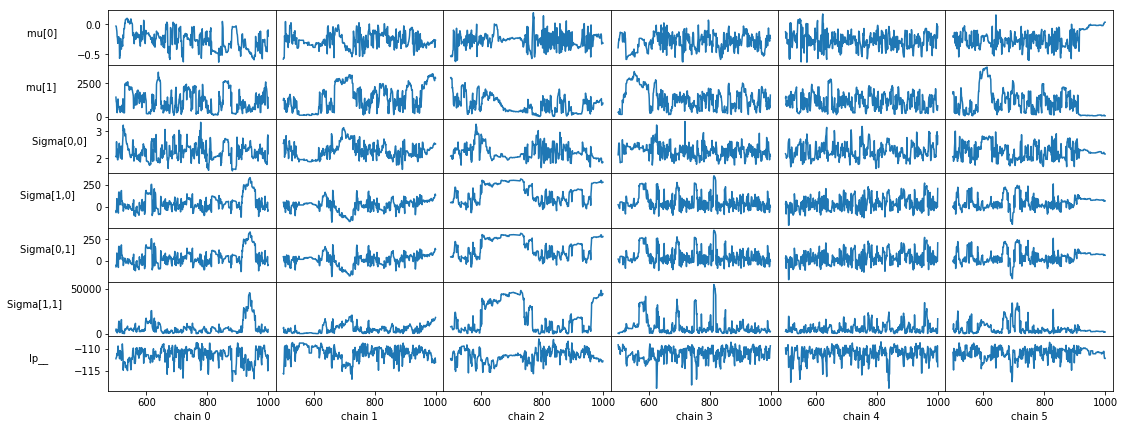

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


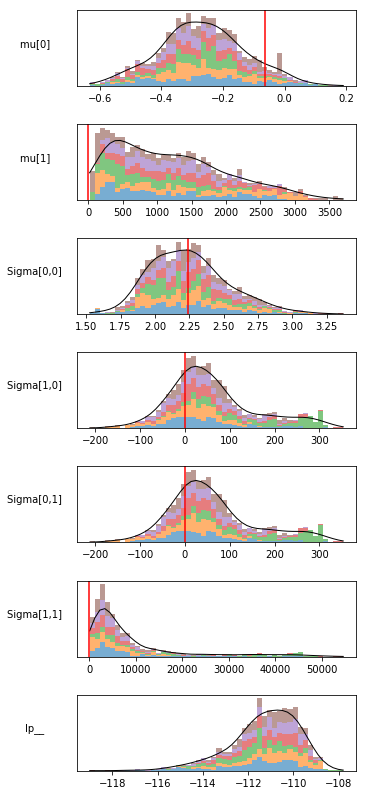

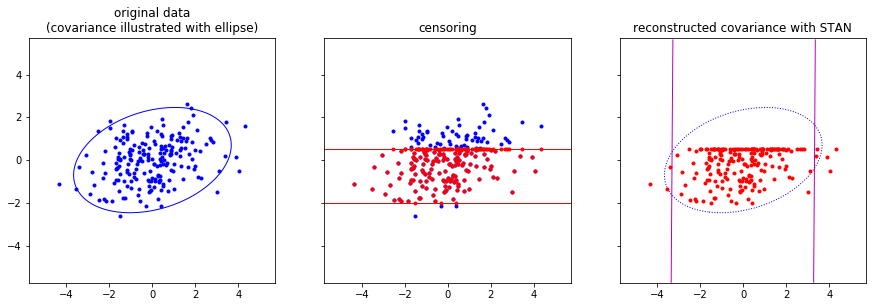

In [7]:
fit_model(truncated_model, data)

### Censored model (with exact marginals)

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


5.440666913986206
Inference for Stan model: anon_model_b6b7d0bf425c85bb156b0d73a809a897.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       -0.06  2.0e-3   0.11  -0.28  -0.13  -0.06 7.6e-3   0.15   3000    1.0
mu[1]      6.1e-3  1.5e-3   0.08  -0.15  -0.05 5.2e-3   0.06   0.17   3000    1.0
Sigma[0,0]   2.31  4.2e-3   0.23   1.89   2.15    2.3   2.45   2.81   3000    1.0
Sigma[1,0]   0.46  2.3e-3   0.13   0.22   0.38   0.46   0.55   0.72   3000    1.0
Sigma[0,1]   0.46  2.3e-3   0.13   0.22   0.38   0.46   0.55   0.72   3000    1.0
Sigma[1,1]   1.13  2.8e-3   0.16   0.86   1.02   1.11   1.22   1.47   3000    1.0
lp__       -303.1    0.04   1.58 -307.1 -303.9 -302.7 -301.9 -301.0   1485    1.0

Samples were drawn using NUTS at Sun Sep 16 16:00:38 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat

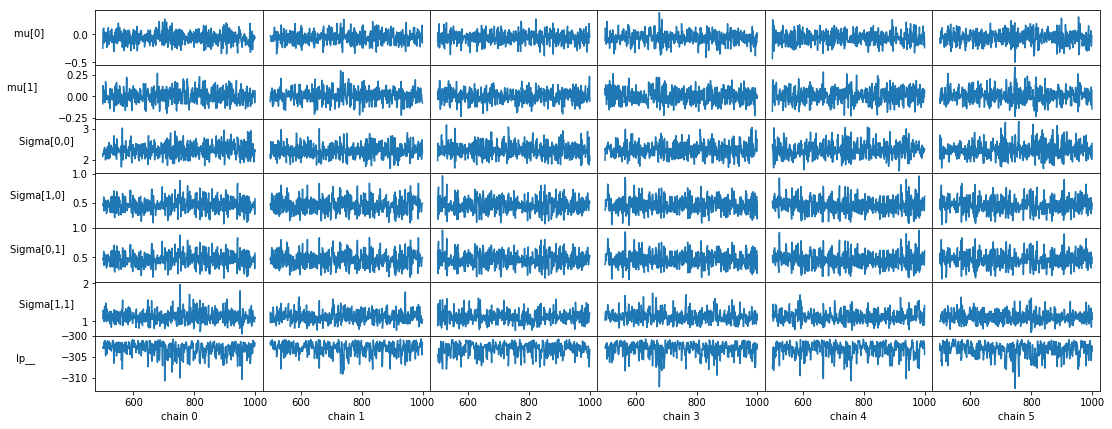

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


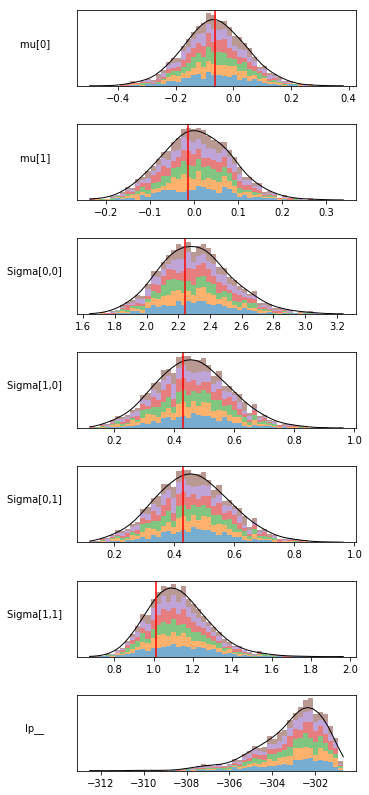

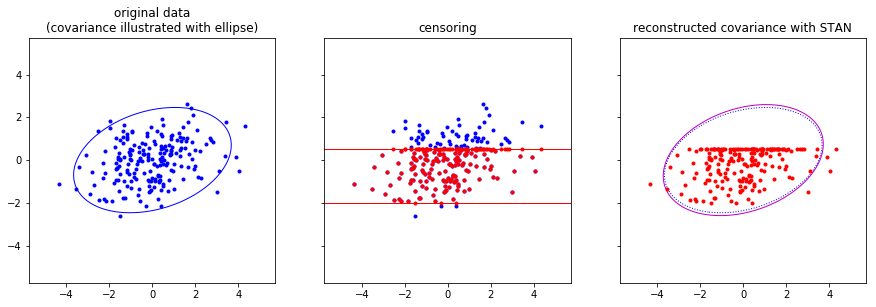

In [8]:
fit_model(censored_model, data)

### Censored model (with latent variables)

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


35.04233694076538
Inference for Stan model: anon_model_7713b4e8f58506e2256a095eabe46dcf.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       -0.06  2.2e-3   0.11  -0.28  -0.13  -0.06   0.01   0.15   2305    1.0
mu[1]      5.0e-3  1.8e-3   0.08  -0.15  -0.05 3.0e-3   0.06   0.16   2064    1.0
Sigma[0,0]   2.31  4.4e-3   0.24   1.89   2.15    2.3   2.46   2.84   3000    1.0
Sigma[1,0]   0.46  2.7e-3   0.13   0.22   0.37   0.46   0.55   0.74   2477    1.0
Sigma[0,1]   0.46  2.7e-3   0.13   0.22   0.37   0.46   0.55   0.74   2477    1.0
Sigma[1,1]   1.13  3.9e-3   0.15   0.87   1.02   1.11   1.22   1.44   1490    1.0
lp__       -335.2    0.25   6.89 -349.5 -339.7 -334.9 -330.5 -322.5    741   1.01

Samples were drawn using NUTS at Sun Sep 16 16:01:19 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat

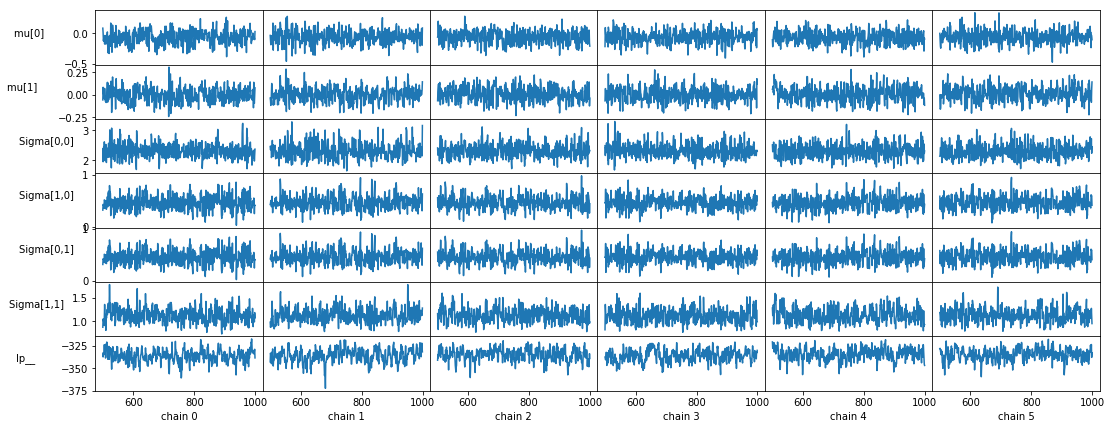

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


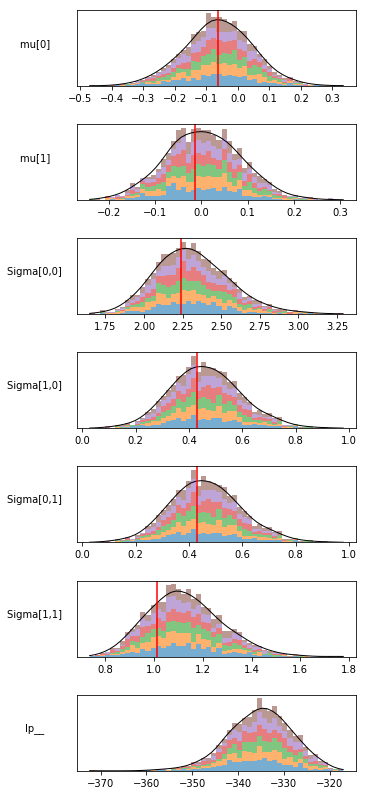

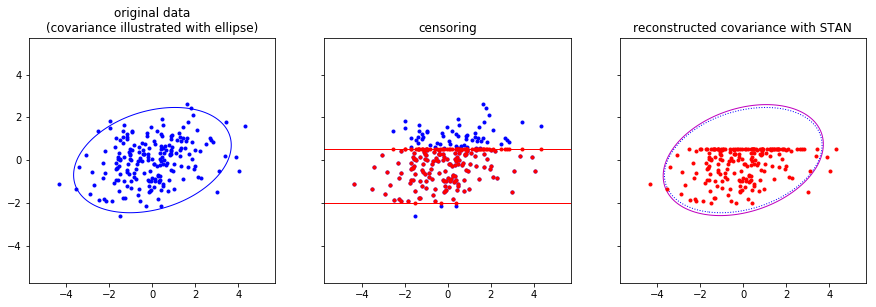

In [9]:
fit_model(censored_latent_model, data)